# Biology and Temperature Normalization

# Import Packages

In [11]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

/Users/akbaskind/Documents/Python Scripts/phyto


# Pull data from [spreadsheet](https://docs.google.com/spreadsheets/d/1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10/edit#gid=0)

- opening all the datasets in the spreadsheet all at once
- `hydrocat620`
- `hydrocat720`
- `MV`
- `QP`

In [2]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

## Correct data types

In [3]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

# Remove effect of biology

Pimenta, A., Oczkowski, A., McKinney, R., & Grear, J., 2023. [Geographical and seasonal patterns in the
carbonate chemistry of Narragansett Bay, RI](https://www.sciencedirect.com/science/article/pii/S2352485523000920), *Regional Studies in Marine Science*, **62**, 102903. 

## Step 1. Get alkalinity

Since we do not have alkalinity from our sensors, we can estimate alkalinity using salinity. Pimenta et al. (2023) provides this relationship for estimating alkalinity [µmol/kg] from salinity [PSU] in estuaries:

$$ 477.62 + 51.99 \times S = TA $$

In [6]:
hydrocat720['Alkalinity'] = 477.62 + 51.99 * hydrocat720['hydrocatSalinity']

## Step 2. Calculate actual DIC

We can use PyCO2SYS to calculate DIC. Remember, to solve the marine carbonate system we need any combination of 2 of the following:

1. Total alkalinity (type `1`) in μmol·kg−1.
2. Dissolved inorganic carbon (type `2`) in μmol·kg−1.
3. pH (type `3`) on the Total, Seawater, Free or NBS scale1. Which scale is given by the argument opt_pH_scale.
4. Any one of:Partial pressure of CO2 (type `4`) in μatm, Fugacity of CO2 (type `5`) in μatm, Aqueous CO2 (type `8`) in μmol·kg−1, or Dry mole fraction of CO2 (type `9`) in ppm.
5. Any one of: Carbonate ion (type `6`) in μmol·kg−1, Saturation state w.r.t. calcite (type `10`), or Saturation state w.r.t. aragonite (type `11`).

We have pH adjusted to temperature and total alkalinity.

We also need to provide certain hydrographic conditions, specifically temperature and salinity.

Thus, the function will take the following form

```python
results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S)
```

`results` is a dictionary containing arrays of all kinds of parameters. We are interested in `dic`.

In [40]:
TA = hydrocat720['Alkalinity']
pH = hydrocat720['adjusted_ph temp']
T = hydrocat720['hydrocatTemperature']
S = hydrocat720['hydrocatSalinity']

results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S)

In [41]:
hydrocat720['DIC_measured'] = results['dic']

## Step 3. Calculate theoretical DIC produced through biology
### Conceptual Overview
#### Oxidation/remineralization of organic matter
The following reaction describes the respiration and photosynthesis of organic matter (Sarmiento & Gruber, 2006). 
$$\require{mhchem}$$   
$$\ce{OM + 150 O2 <=> 106 CO2 + 16 HNO3 + H3PO4 + 78 H2O}$$

#### Redfield Ratio
From this reaction, we arrive at the Redfield ratio: $106 C: 16 N: 1 P: 150 O_2$. We can rewrite this ratio in terms of DIC and TA as follows: $106\ \text{DIC}: -17\ \text{TA}: 150\ \text{O}_2$

*This is an explanation I wrote in a homework assigment for why the Redfield ratio in terms of DIC and TA is what it is.* The reaction produces 106 moles of carbon for every 150 moles of oxygen consumed (i.e. cell respiration), or it consumes 106 moles of carbon for every 150 moles of oxygen produced (i.e. photosynthesis). Further, the respiration of organic matter produces 16 moles of NO$_3^-$ and 1 mole of HPO$_4^{2-}$. Alkalinity under one definition is the ability of a solution to react with additional H$^+$. Generally, the charge of an anion is equal to the number of protons it will accept, except in the case of HPO$_4^{2-}$. HPO$_4^{2-}$ only accepts 1 proton to become H$_2$PO$_4^{-}$. Thus, 1 mole of NO$_3^-$ and 1 mole of HPO$_4^{2-}$ will each accept 1 mole of protons. Since we have 16 moles of NO$_3^-$, we multiply to get 16 moles of protons. In total, the products of aerobic respiration can accept 17 moles of H$^+$. This increases the free hydrogens in the solution and thus decreases alkalinity by 17 moles (or mole equivalents). 

#### AOU
AOU, or apparent oxygen utilization, is the difference between oxygen saturation and measured oxygen. The oxygen saturation concentration is the maximum amount of oxygen soluble a water parcel with a given temperature and given salinity. Though salinity does influence solubility, solubility is dominated by temperature.

$$\text{AOU}=[O_{2}]_{\text{saturation}}-[O_{2}]_{\text{observed}}$$

Biology is the primary sink for oxygen in the ocean, so this difference in oxygen, the AOU, is often understood to be the amount of oxygen consumed by biology. Thus, we can use AOU with the Redfield ratio to determine how much DIC is produced based on how much oxygen is consumed. 

I wrote a function that calculates saturation oxygen: `PLT.o2sat(S,T)`. It outputs oxygen saturation concentration in umol/L. *Note that most of our sensors provide dissolved oxygen in mg/kg so we need to convert units.*

#### Overview
To summarize, we can calculate the theoretical DIC produced from biology alone using AOU and the Redfield ratio as follows:

$$ \text{DIC}_{\text{theoretical}} = \text{AOU} \times \frac{106 \ \text{C}}{150 \ \text{O}_2}$$


### Step 3a. Convert oxygen units

Since our `o2sat(S,T)` function has units of umol/kg and our sensor DO has units of mg/L, let's convert our sensor DO to umol/kg. Remember that oxygen (O$_2$) is 32 g/mol.

$$ 
\frac{\color{purple}{\text{mg}_{\text{O2}}}}{\color{blue}{\text{L}}} \times \frac{\color{red}{1000} \color{blue}{\text{L}}}{1 \color{green}{\text{m}^3}} \times \frac{\color{green}{\text{m}^3}}{\text{kg}_{\text{w}}} \times \frac{\color{brown}{\text{g}}}{\color{red}{1000}\ \color{purple}{\text{mg}}} \times \frac{\color{orange}{\text{mol}_{\text{O2}}}}{32\ \color{brown}{\text{g}_{\text{O2}}}} \times \frac{10^6\ \text{umol}}{1\ \color{orange}{\text{mol}}}
$$

$$ 
\text{DO}_{\frac{\text{mg}}{\text{L}}} \times \frac{1}{\rho_{\text{w}}} \times \frac{1}{32} \times 10^6 = \frac{\text{umol}}{\text{kg}}
$$
As the above equation shows, we need to first calculate density. I have done this using `gsw.rho(S,T,P)` and set the pressure `P` to zero since this is the surface ocean. 


In [116]:

hydrocat720['Density'] = gsw.rho(hydrocat720['hydrocatSalinity'].to_numpy(), 
                                 hydrocat720['hydrocatTemperature'].to_numpy(), 
                                 np.zeros(len(hydrocat720['hydrocatSalinity'])))
hydrocat720['DO [umol/kg]'] = (hydrocat720['hydrocatDissOxygen'] * 1e6) / (32 * hydrocat720['Density'])

We can see units REALLY matter here (my bad for absolutely blundering the units initially haha).

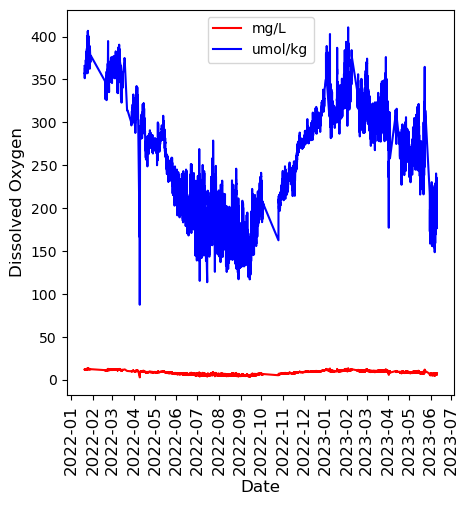

In [123]:
fig, ax = plt.subplots(figsize = [5,5])

ax.plot(hydrocat720["DateTime"],hydrocat720['hydrocatDissOxygen'],color="red", label = 'mg/L')

# set x-axis label
ax.set_xlabel("Date", fontsize = 12)
# set y-axis label
ax.set_ylabel("Dissolved Oxygen" ,fontsize=12)

ax.plot(hydrocat720["DateTime"], hydrocat720['DO [umol/kg]'],color="blue", label = 'umol/kg')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.legend()


### Step 3b. Calculate saturation oxygen concentration

We can see that O2 saturation and temperature (which I converted to Kelvin just so I could put everything on the same axis) are inversely correlated.

In [124]:
hydrocat720['O2 sat'] = PLT.o2sat(hydrocat720['hydrocatSalinity'], hydrocat720['hydrocatTemperature'])

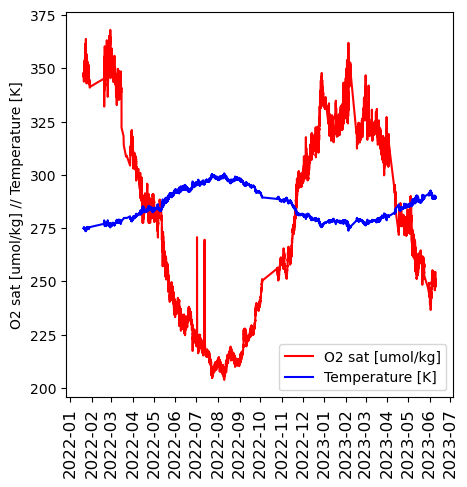

In [130]:
fig, ax = plt.subplots(figsize = [5,5])

ax.plot(hydrocat720["DateTime"],hydrocat720['O2 sat'],color="red", label = 'O2 sat [umol/kg]')
ax.plot(hydrocat720["DateTime"],hydrocat720['hydrocatTemperature'] + 273,color="blue", label = 'Temperature [K]')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.set_ylabel('O2 sat [umol/kg] // Temperature [K]')
ax.legend()

### Step 3c. Calculate AOU

$$\text{AOU}=[O_{2}]_{\text{saturation}}-[O_{2}]_{\text{observed}}$$

Hongjie noted that AOU should be negative during certain parts of the year in Narragansett Bay, when production outpaces respiration (i.e. during blooms). My initial attempt did not capture this because of an error in unit conversions. Here, it is corrected and we do, in fact, see negative AOUs, particularly in the winter and spring.

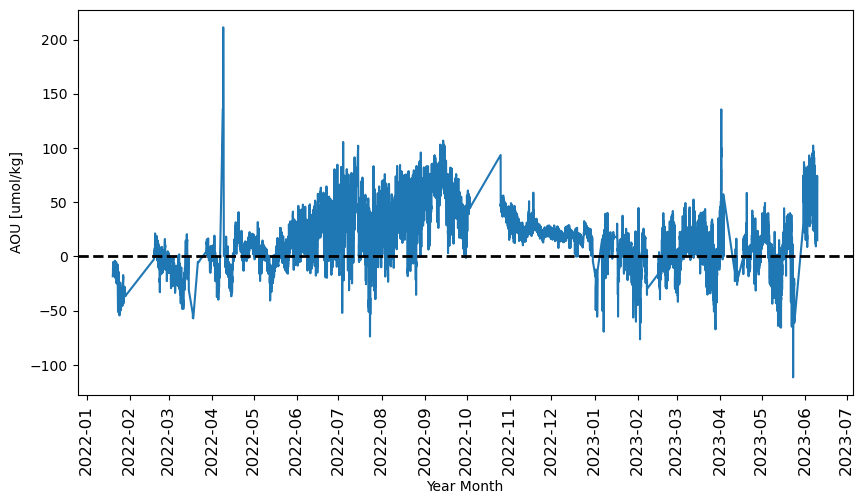

In [134]:
hydrocat720['AOU'] = hydrocat720['O2 sat'] - hydrocat720['DO [umol/kg]']

fig, ax = plt.subplots(figsize = [10,5])
ax.plot(hydrocat720["DateTime"],hydrocat720['AOU'])
ax.set_xlabel('Year Month')
ax.set_ylabel('AOU [umol/kg]')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

### Step 3d. Multiply AOU by the Redfield ratio to get ∆DIC

∆DIC here represents the amount of DIC *produced* through respiration. The sign may be negative, indicating DIC is actually net produced through photosynthesis. Since the positive direction represents consumption, we will want to subtract ∆DIC from DIC measured.

In [138]:
C_to_O2 = 106/150

hydrocat720['∆DIC'] = hydrocat720['AOU'] * C_to_O2

## Step 4. Recalculate pH using Alkalinity and DIC theoretical

Since we want to remove the effect of biology, we will substract the DIC produced through respiration (∆DIC) from the measured DIC. We will use that new DIC ($\text{DIC}_{\text{measured}} - \Delta \text{DIC}$) to calculate a new pH.

In [139]:
TA = hydrocat720['Alkalinity']
DIC = hydrocat720['DIC_measured'] - hydrocat720['∆DIC']
T = hydrocat720['hydrocatTemperature']
S = hydrocat720['hydrocatSalinity']

results = pyco2.sys(par1 = TA, par2 = DIC, par1_type = 1, par2_type = 2, temperature = T, salinity = S)
hydrocat720['pH theoretical'] = results['pH']

In [140]:
hydrocat720[['AOU', 'adjusted_ph temp', 'Alkalinity', '∆DIC',
       'DIC_measured', 'pH theoretical']]

,AOU,adjusted_ph temp,Alkalinity,∆DIC,DIC_measured,pH theoretical
0,-18.328173,8.466929,2009.021843,-12.951909,1756.791784,8.439743
1,-17.972674,8.442756,2010.046046,-12.700690,1768.892538,8.415393
2,-17.496243,8.450796,2010.519155,-12.364012,1765.341328,8.424433
3,-17.413215,8.460270,2010.711518,-12.305338,1760.925867,8.434324
4,-17.482790,8.460629,2010.680324,-12.354505,1760.749639,8.434586
...,...,...,...,...,...,...
35572,36.502225,7.784883,2016.186065,25.794906,1930.646186,7.866905
35573,26.364158,7.814661,2013.919301,18.630672,1919.078618,7.872846
35574,19.110956,7.834495,2014.408007,13.505076,1912.829844,7.876075
35575,14.945487,7.854425,2012.801516,10.561477,1904.927658,7.886445


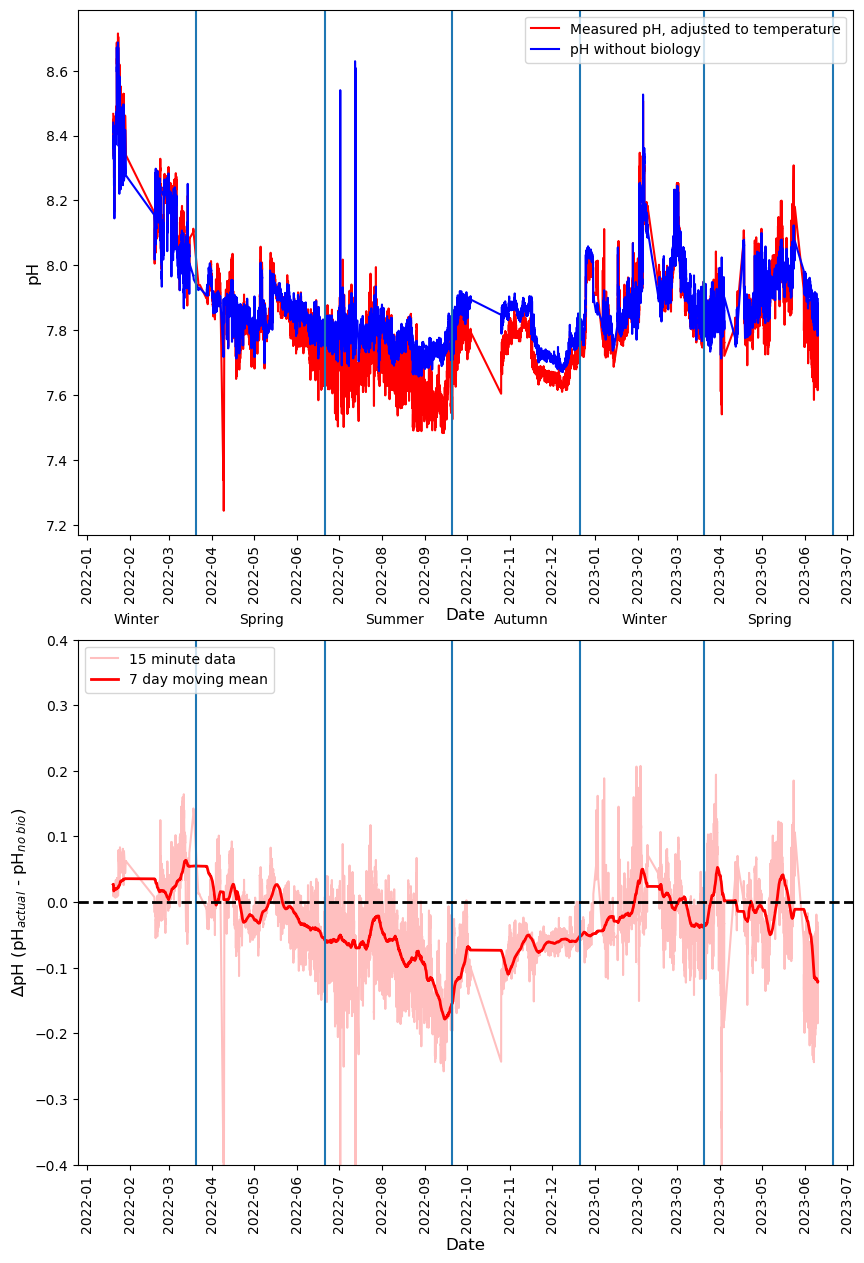

In [155]:
fig, ax = plt.subplots(nrows = 2, figsize = [10,15])

# First subplot: Plot both pH time series
ax[0].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp'],color="red", label = 'Measured pH, adjusted to temperature')
ax[0].plot(hydrocat720["DateTime"],hydrocat720['pH theoretical'],color="blue", label = 'pH without biology')

# set x-axis label
ax[0].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[0].set_ylabel("pH",fontsize=12)

ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].tick_params('x',labelsize = 10, labelrotation = 90)
ax[0].legend()

ax[0].axvline(datetime(2022, 3, 20))
ax[0].axvline(datetime(2022, 6, 21))
ax[0].axvline(datetime(2022, 9, 20))
ax[0].axvline(datetime(2022, 12, 21))
ax[0].axvline(datetime(2023, 3, 20))
ax[0].axvline(datetime(2023, 6, 21))

# Subplot 2: plot the difference in the pH
ax[1].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp'] - hydrocat720['pH theoretical'] ,color="red", alpha = 0.25, label = '15 minute data')
ax[1].plot(hydrocat720["DateTime"], 
           bn.move_mean(hydrocat720['adjusted_ph temp'] - hydrocat720['pH theoretical'], window=96*7, min_count=1), 
           color='red', linewidth = 2, label = '7 day moving mean')
# set x-axis label
ax[1].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[1].set_ylabel("∆pH (pH$_{actual}$ - pH$_{no\ bio})$",fontsize=12)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].tick_params('x',labelsize = 10, labelrotation = 90)
ax[1].set_ylim([-0.4,0.4])
ax[1].legend()

ax[1].text(datetime(2022, 1, 20), 0.425, 'Winter')
ax[1].axvline(datetime(2022, 3, 20))
ax[1].text(datetime(2022, 4, 20), 0.425, 'Spring')
ax[1].axvline(datetime(2022, 6, 21))
ax[1].text(datetime(2022, 7, 20), 0.425, 'Summer')
ax[1].axvline(datetime(2022, 9, 20))
ax[1].text(datetime(2022, 10, 20), 0.425, 'Autumn')
ax[1].axvline(datetime(2022, 12, 21))
ax[1].text(datetime(2023, 1, 20), 0.425, 'Winter')
ax[1].axvline(datetime(2023, 3, 20))
ax[1].text(datetime(2023, 4, 20), 0.425, 'Spring')
ax[1].axvline(datetime(2023, 6, 21))
ax[1].axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

## Observations of effect of biology
We can see in the first subplot, biology does in fact have a noticeable effect on the pH in Narragansett Bay. To better understand what that effect is, I plotted the anomaly in the second subplot. I defined by anomaly as the measured pH minus the theoretical pH (the pH without the effect of biology), such that when biology decreases (increases) the pH the anomaly will be negative (positive). Further, I took a 7 day moving mean of the anomaly to take out some of the noise and help us make some very general conclusions. Here are my primary observations.

1. ∆pH is clearly negative in the summer and the fall.
2. ∆pH is positive more often in the winter and the spring.
3. ∆pH is never *consistently* positive. It will make a positive excursion and then become negative again, such that no season is entirely positive in the mean, excluding winter of 2022 where data is sparse.
4. ∆pH is highly variable on diurnal timescales below the resolution of the moving mean.

Here is what I gather from these observations.

1. Biology has an overall negative effect on pH (i.e. acidifying) in the summer and fall. This aligns with our understanding that the summer and fall are post-bloom periods in Narragansett Bay, so respiration exceeds production and becomes a CO2 source.
2. Biology has a positive effect periodically in the winter and spring, when we expect phytoplankton blooms in the bay.
3. The brief positive effects of biology on pH may correspond with the timing of the bloom. The bloom, in my experience, lasts only a few weeks at most. So while the winter and spring are the bloom seasons, the positive imprint on pH ends quickly after the bloom. This is to say, there is a subseasonal variability that appears tightly coupled to the exact timing of blooms.
4. Clearly, biology has diurnal effects on pH that have been glossed over in the 7 day moving mean. The magnitude of this diurnal variability seems to vary across seasons.

# Remove effect of temperature
## Step 1. Find the annual mean temperature

Since we have more than 1 year of data here, we need to isolate 1 year.

In [94]:
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 31)
H720_2022 = hydrocat720.where(hydrocat720['DateTime'] >= start).where(hydrocat720['DateTime'] <= end).dropna()
mean_temp = H720_2022['hydrocatTemperature'].mean()
mean_temp

15.481207442187456

## Step 2. Normalize to temperature using PyCO2SYS

Once again, we will use alkalinity and pH (temperature adjusted). This time we will use the keyword argument `temperature_out` to specify we want our results at a specific output temperature.

```python
results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S, temperature_out = mean_temp)
```

The output we want from results is `pH_out`.

In [104]:
TA = hydrocat720['Alkalinity']
pH = hydrocat720['adjusted_ph temp']
T = hydrocat720['hydrocatTemperature']
S = hydrocat720['hydrocatSalinity']

results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S, 
                    temperature_out = mean_temp)
hydrocat720['pH (temperature normalized)'] = results['pH_out']

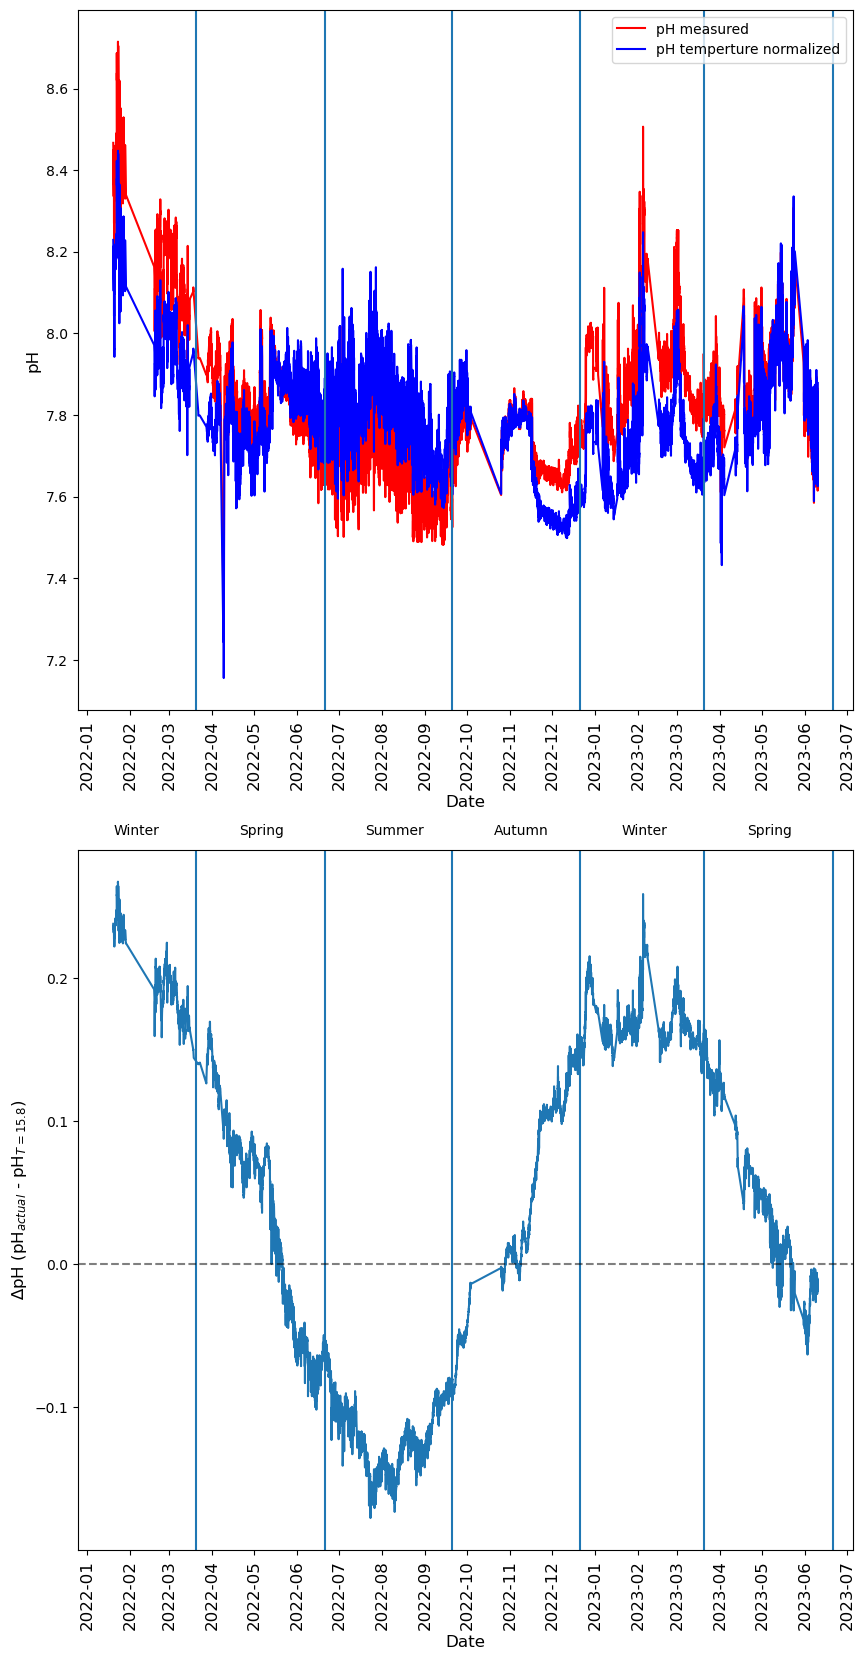

In [111]:
fig, ax = plt.subplots(nrows = 2, figsize = [10,20])

ax[0].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp'], color = 'red', label = 'pH measured')
ax[0].plot(hydrocat720["DateTime"],hydrocat720['pH (temperature normalized)'], color = 'blue', label = 'pH temperture normalized')
# set x-axis label
ax[0].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[0].set_ylabel("pH",fontsize=12)

ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].tick_params('x',labelsize = 12, labelrotation = 90)
ax[0].legend()

ax[0].axvline(datetime(2022, 3, 20))
ax[0].axvline(datetime(2022, 6, 21))
ax[0].axvline(datetime(2022, 9, 20))
ax[0].axvline(datetime(2022, 12, 21))
ax[0].axvline(datetime(2023, 3, 20))
ax[0].axvline(datetime(2023, 6, 21))

ax[1].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp']-hydrocat720['pH (temperature normalized)'])

# set x-axis label
ax[1].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[1].set_ylabel("∆pH (pH$_{actual}$ - pH$_{T = 15.8}$)",fontsize=12)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].tick_params('x',labelsize = 12, labelrotation = 90)
ax[1].text(datetime(2022, 1, 20), 0.3, 'Winter')
ax[1].axvline(datetime(2022, 3, 20))
ax[1].text(datetime(2022, 4, 20), 0.3, 'Spring')
ax[1].axvline(datetime(2022, 6, 21))
ax[1].text(datetime(2022, 7, 20), 0.3, 'Summer')
ax[1].axvline(datetime(2022, 9, 20))
ax[1].text(datetime(2022, 10, 20), 0.3, 'Autumn')
ax[1].axvline(datetime(2022, 12, 21))
ax[1].text(datetime(2023, 1, 20), 0.3, 'Winter')
ax[1].axvline(datetime(2023, 3, 20))
ax[1].text(datetime(2023, 4, 20), 0.3, 'Spring')
ax[1].axvline(datetime(2023, 6, 21))
ax[1].axhline(y=0.0, color='k', linestyle='dashed', alpha = 0.5)

## Observations on the effect of temperature

Based on ∆pH, we see that cooler winter temperatures increase pH. Warmer summer temperatures decrease pH.